In [1]:
# Load trained latent prediction models, and generate rate-accuracy curve for RFW.
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
import json

# project modules
from predict import perform_inference
import rfw_loader 
from datasets.rfw_latent import RFW_raw, RFW_latent, create_dataloaders
from train import train, write_model, save_model
# from detection_models import MultiHeadResNet, LatentMultiHead_1
from latent_utils import get_latent
from RFW_utils import save_race_based_predictions_latent, save_race_based_predictions, load_predictions, get_classification_report

# neural compression model
import sys
sys.path.append('/home/tianqiu/NeuralCompression/lossy-vae')
from lvae import get_model
from lvae.models.qresvae import zoo

In [2]:
DECODED_IMAGE_ROOT='/media/global_data/fair_neural_compression_data/decoded_rfw'
output_dims = {
    'skin_type': 6,
    'eye_type': 2,
    'nose_type': 2,
    'lip_type': 2,
    'hair_type': 4,
    'hair_color': 5
}
categories = list(output_dims.keys())
races = ['Indian', 'Asian', 'African', 'Caucasian']

In [3]:
data_rates=[1, 3, 6, 9, 12]
latent_model_dict= {
    1:'../models/latent_RFW_latent_n_keep_1_epoch_43.pth',
    3:'../models/latent_RFW_latent_n_keep_3_epoch_63.pth',
    6:'../models/latent_RFW_latent_n_keep_6_epoch_29.pth',
    9:'../models/latent_RFW_latent_n_keep_9_use_pretrained_epoch_66.pth',
    12:'../models/latent_RFW_latent_n_keep_12_use_pretrained_epoch_63.pth',
}

In [4]:
DEVICE = 1
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device
# n_keep = 12
# model_path = '../models/latent_RFW_numerical_all_labels_n_keep_1.pth'
# model_path = '../models/latent_RFW_numerical_all_labels_resent18_retrain_n_keep_12.pth'
# model_path = model_dict[n_keep]
# model_name = Path(model_path).stem # keep stem, remove parents and ext.
# print(model_name)
# model = torch.load(model_path).to(device)

device(type='cuda', index=1)

In [5]:
nc_model_name = 'qres17m'
lmb_value = 64
nc_model = get_model(nc_model_name, lmb_value, pretrained=True).to(device) # weights are downloaded automatically

### create 64x64 image loaders for creating latents

In [6]:
BATCH_SIZE=1024

RFW_IMAGES_DIR =  "/media/global_data/fair_neural_compression_data/datasets/RFW/data_64"
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
image_ds = RFW_raw(RFW_IMAGES_DIR, RFW_LABELS_DIR)
_, val_loader, test_loader = create_dataloaders(
    image_ds,
    BATCH_SIZE, 
)

### make predictions for first time, or load results from before

In [7]:
# save all predictions and labels
load_results = True
for n_keep in data_rates:
    model_path = latent_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    model = torch.load(model_path).to(device)
    if not load_results:
        all_predictions, all_labels = save_race_based_predictions_latent(nc_model, 
                                                        n_keep, 
                                                        model,
                                                        model_name,
                                                        test_loader, 
                                                        device, 
                                                        f'../results/latent_RFW_test/predictions/{n_keep}',
                                                        save_labels=True
                                                    )
    else:
        # directly load existing results
        all_predictions, all_labels = load_predictions(model_name, f'../results/latent_RFW_test/predictions/{n_keep}')


### create list of metrics for latent prediction models

In [8]:
latent_performance_metrics = []
for n_keep in data_rates:
    model_path = latent_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    performance = get_classification_report(
            races,
            categories,
            f'../results/latent_RFW_test/predictions/{n_keep}',
            model_name
        )
    latent_performance_metrics.append(performance)

### create image dataloaders for image space prediction

In [9]:
class MultiHeadResNet(nn.Module):
    def __init__(self, output_dims):
        super(MultiHeadResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.heads = nn.ModuleDict()
        for head, num_classes in output_dims.items():
            self.heads[head] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.resnet(x).squeeze()
        outputs = {}
        for head, head_module in self.heads.items():
            output_logits = head_module(features)
            outputs[head] = F.softmax(output_logits, dim=1)
        return outputs

In [10]:
image_model_dict= {
    1:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth',
    3:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth',
    6:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth',
    9:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth',
    12:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth',
}

In [11]:
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"

In [12]:
load_results = False
for n_keep in data_rates:
    compressed_image_path = f'{DECODED_IMAGE_ROOT}/progressive_64x64/qres17m/q_64/{n_keep}'
    _, _, test_loader = rfw_loader.create_dataloaders(
        compressed_image_path, 
        RFW_LABELS_DIR, 
        BATCH_SIZE, 
    )
    model_path = image_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    model = torch.load(model_path).to(device)
    if not load_results:
        image_all_predictions, image_all_labels = save_race_based_predictions(
                                                        model,
                                                        model_name,
                                                        test_loader, 
                                                        device, 
                                                        f'../results/RFW_test/predictions/{n_keep}',
                                                        save_labels=True
                                                    )
    else:
        # directly load existing results
        image_all_predictions, image_all_labels = load_predictions(model_name, f'../results/RFW_test/predictions/{n_keep}')

/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


prediction_save_dir: ../results/RFW_test/predictions/1


Getting Predictions: 100%|██████████| 6/6 [00:05<00:00,  1.09batch/s]
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


prediction_save_dir: ../results/RFW_test/predictions/3


Getting Predictions: 100%|██████████| 6/6 [00:05<00:00,  1.17batch/s]
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


prediction_save_dir: ../results/RFW_test/predictions/6


Getting Predictions: 100%|██████████| 6/6 [00:05<00:00,  1.17batch/s]
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


prediction_save_dir: ../results/RFW_test/predictions/9


Getting Predictions: 100%|██████████| 6/6 [00:05<00:00,  1.16batch/s]
/home/tianqiu/.conda/envs/torch2_2/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


prediction_save_dir: ../results/RFW_test/predictions/12


Getting Predictions: 100%|██████████| 6/6 [00:05<00:00,  1.15batch/s]


In [14]:
image_performance_metrics = []
for n_keep in data_rates:
    model_path = image_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    performance = get_classification_report(
            races,
            categories,
            f'../results/RFW_test/predictions/{n_keep}',
            model_name
        )
    image_performance_metrics.append(performance)

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# latent_prediction_metrics = {}
# for race in all_predictions:
#     latent_prediction_metrics[race] = {}
#     for category in all_predictions[race]:
#         latent_prediction_metrics[race][category] = {}
        
#         preds = all_predictions[race][category]
#         labels = all_labels[race][category]
#         latent_prediction_metrics[race][category]['accuracy'] = accuracy_score(labels, preds)
#         latent_prediction_metrics[race][category]['precision'] = precision_score(labels, preds, average='weighted')
#         latent_prediction_metrics[race][category]['recall'] = recall_score(labels, preds, average='weighted')
#         latent_prediction_metrics[race][category]['f1'] = f1_score(labels, preds, average='weighted')

In [15]:
bpps = []
for data_rate in data_rates:
    json_path = f'{DECODED_IMAGE_ROOT}/progressive_64x64/qres17m/q_64/{data_rate}/stats.json'
    with open(json_path, 'r') as json_file:
        data_dict = json.load(json_file)
        bpps.append(data_dict['results']['bpp'])

### comaprison between prediction on decoded image vs latent

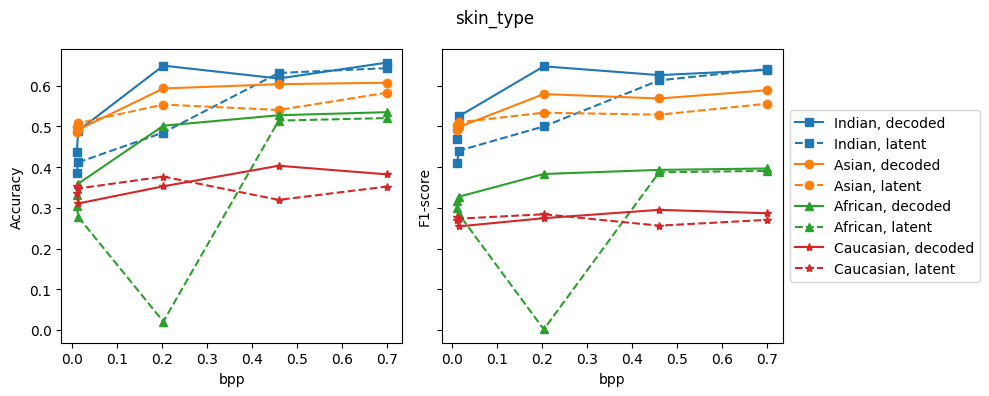

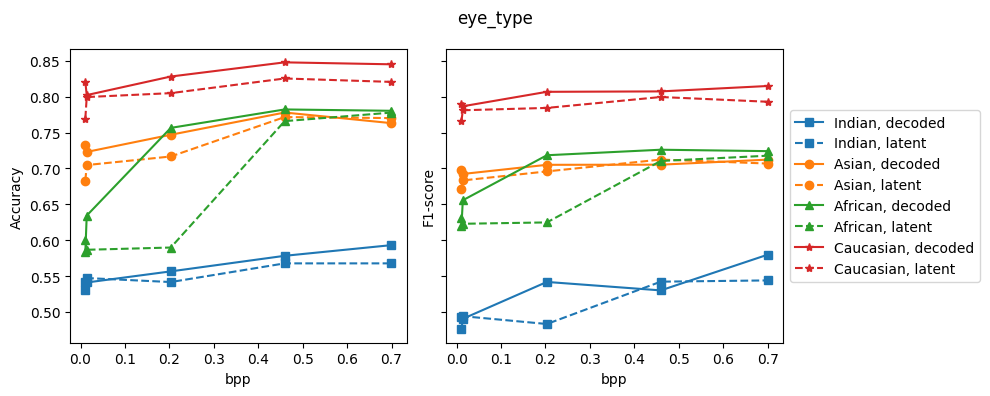

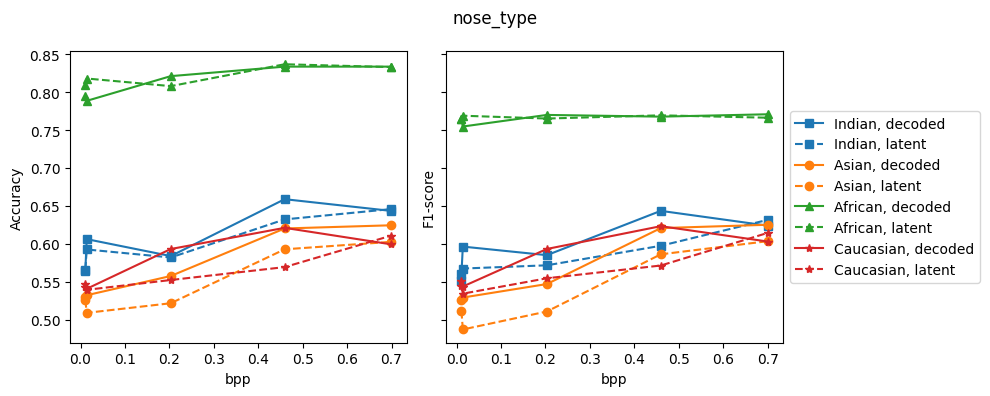

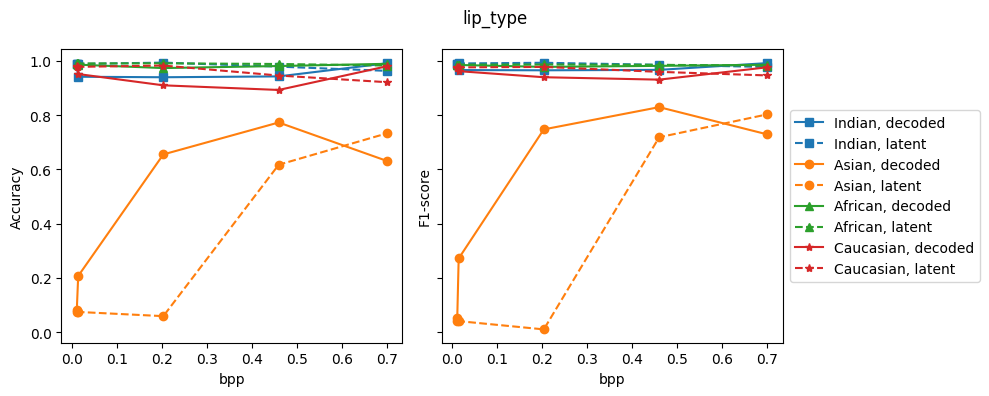

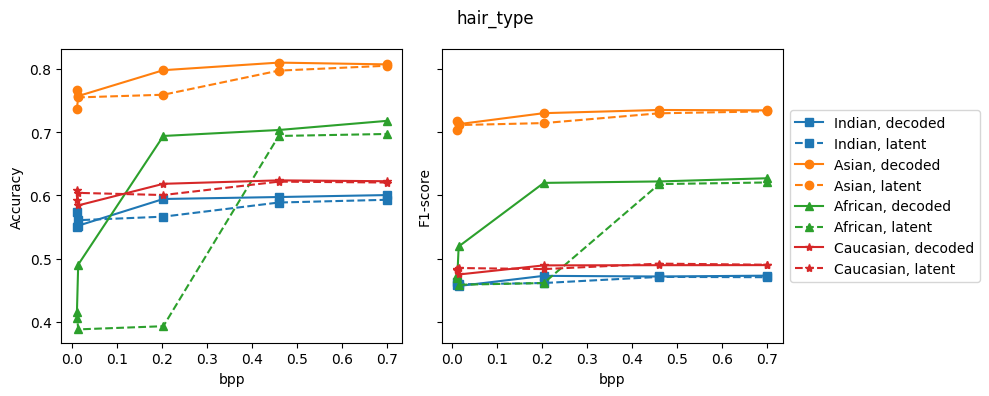

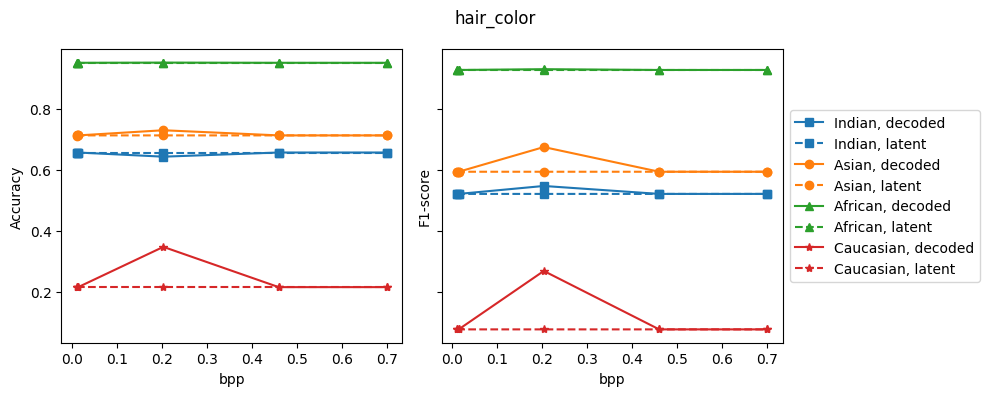

In [42]:
all_metrics_plot_path="../results/latent_RFW_test/plots"
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
race_markers = ['s', 'o', '^', '*']

# fig, axes = plt.subplots(6, 2, figsize=(10, 20), sharex=True, sharey=True)

for i, category in enumerate(categories):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for j, race in enumerate(races):
        latent_race_accuracies, latent_race_f1_scores = [], []
        image_race_accuracies, image_race_f1_scores = [], []

        for k, data_rate in enumerate(data_rates):
            # latent plot data
            latent_race_accuracies.append(latent_performance_metrics[k]['acc'][category][race])
            latent_race_f1_scores.append(latent_performance_metrics[k]['f1'][category][race])
            # image plot data
            image_race_accuracies.append(image_performance_metrics[k]['acc'][category][race])
            image_race_f1_scores.append(image_performance_metrics[k]['f1'][category][race])
        axes[0].plot(bpps, image_race_accuracies, marker=race_markers[j], color=colors[j], label=race+', decoded')
        axes[1].plot(bpps, image_race_f1_scores, marker=race_markers[j], color=colors[j], label=race+', decoded')

        axes[0].plot(bpps, latent_race_accuracies, marker=race_markers[j], color=colors[j], linestyle='dashed', label=race+', latent')
        axes[1].plot(bpps, latent_race_f1_scores, marker=race_markers[j], color=colors[j], linestyle='dashed', label=race+', latent')

        axes[1].set_xlabel('bpp')
        axes[0].set_xlabel('bpp')
        axes[0].set_ylabel('Accuracy')
        axes[1].set_ylabel('F1-score')
        
        # axes[0].legend()
        axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(category)
    plt.tight_layout()
    plt.savefig(f'{all_metrics_plot_path}/latent_vs_image_prediction_{category}.png', dpi=200)
    plt.show()

0
1
2
3
4
5


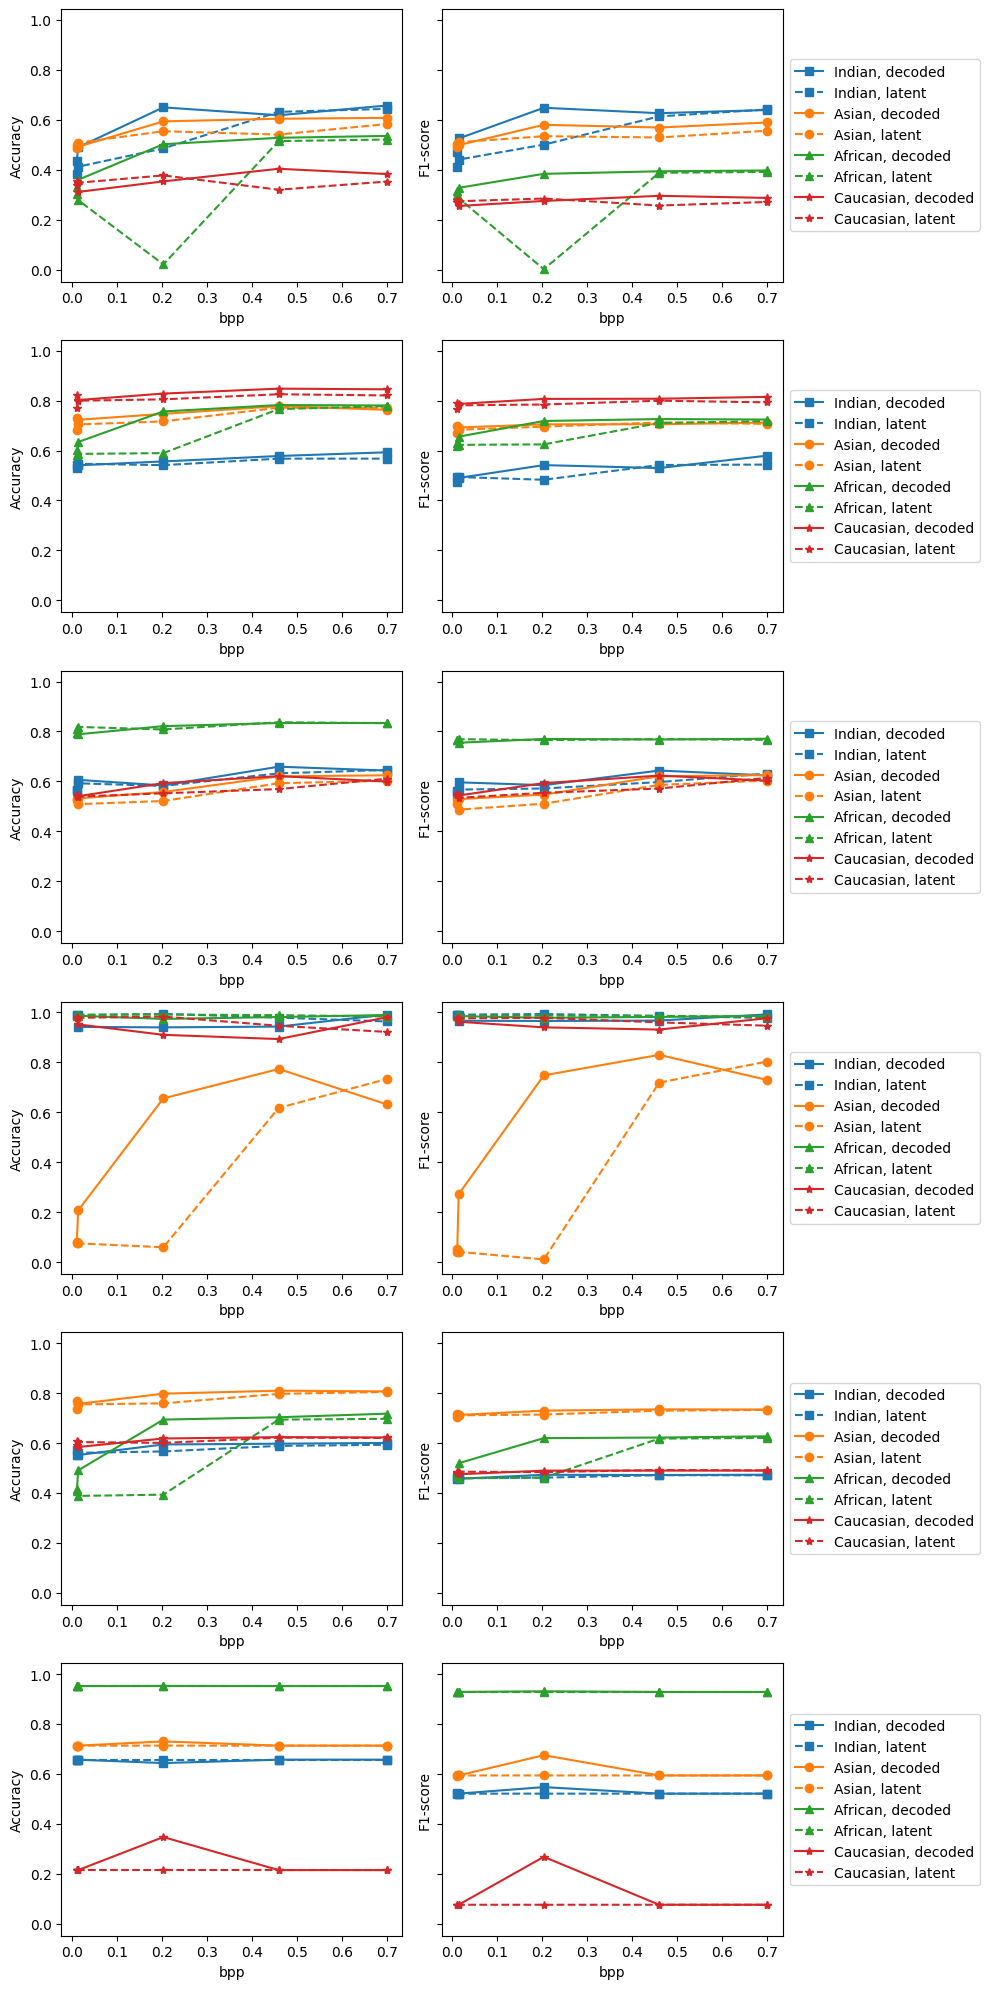

In [46]:
# one big figure
fig, axes = plt.subplots(6, 2, figsize=(10, 20),sharey=True)
for i, category in enumerate(categories):
    print(i)
    # fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for j, race in enumerate(races):
        latent_race_accuracies, latent_race_f1_scores = [], []
        image_race_accuracies, image_race_f1_scores = [], []

        for k, data_rate in enumerate(data_rates):
            # latent plot data
            latent_race_accuracies.append(latent_performance_metrics[k]['acc'][category][race])
            latent_race_f1_scores.append(latent_performance_metrics[k]['f1'][category][race])
            # image plot data
            image_race_accuracies.append(image_performance_metrics[k]['acc'][category][race])
            image_race_f1_scores.append(image_performance_metrics[k]['f1'][category][race])
        axes[i][0].plot(bpps, image_race_accuracies, marker=race_markers[j], color=colors[j], label=race+', decoded')
        axes[i][1].plot(bpps, image_race_f1_scores, marker=race_markers[j], color=colors[j], label=race+', decoded')

        axes[i][0].plot(bpps, latent_race_accuracies, marker=race_markers[j], color=colors[j], linestyle='dashed', label=race+', latent')
        axes[i][1].plot(bpps, latent_race_f1_scores, marker=race_markers[j], color=colors[j], linestyle='dashed', label=race+', latent')

        axes[i][1].set_xlabel('bpp')
        axes[i][0].set_xlabel('bpp')
        axes[i][0].set_ylabel('Accuracy')
        axes[i][1].set_ylabel('F1-score')
        
        # axes[0].legend()
        axes[i][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.suptitle(category)
plt.tight_layout()
# plt.savefig(f'{all_metrics_plot_path}/latent_vs_image_prediction_{category}.png', dpi=200)
plt.show()

In [ ]:
# compare with predictions from n_keep 1 images
# image_predictions = load_predictions(model, 'RFW_numerical_all_labels_resnet18', f'../results/RFW/predictions/progressive/q_64/{n_keep}')
# preds, labels = save_race_based_predictions(
#     model, 
#     f'{MODEL_NAME}_lambda={lambda_value}_datarate={data_rate}', 
#     test_loader, 
#     device, 
#     PRED_SAVE_DIR,
#     save_labels=True
# )
# image_predictions

In [ ]:
# image_prediction_metrics = {}
# for race in image_predictions:
#     image_prediction_metrics[race] = {}
#     for category in image_predictions[race]:
#         image_prediction_metrics[race][category] = {}
        
#         preds = image_predictions[race][category]
#         labels = all_labels[race][category]
#         image_prediction_metrics[race][category]['accuracy'] = accuracy_score(labels, preds)
#         image_prediction_metrics[race][category]['precision'] = precision_score(labels, preds, average='weighted')
#         image_prediction_metrics[race][category]['recall'] = recall_score(labels, preds, average='weighted')
#         image_prediction_metrics[race][category]['f1'] = f1_score(labels, preds, average='weighted')

In [ ]:
# import numpy as np
# ind = np.arange(4)
# width = 0.2
# for race in latent_prediction_metrics:
    
#     fig, axs = plt.subplots(1, len(latent_prediction_metrics['Indian']), figsize=(24, 5))
#     for i, ((category, latent_metrics), (_, image_metrics)) in enumerate(zip(latent_prediction_metrics[race].items(), image_prediction_metrics[race].items())):
#         axs[i].bar(ind-0.1, latent_metrics.values(), width, label='latent')
#         axs[i].bar(ind+0.1, image_metrics.values(), width, label='decoded image')
#         axs[i].set_title(category)
#         axs[i].set_ylabel('Score')
#         axs[i].set_ylim(0, 1)  # Limit y-axis to range [0, 1] for better visualization
#         axs[i].set_xticks(ind)
#         axs[i].set_xticklabels(latent_metrics.keys())
#     plt.legend(loc='best')
#     plt.savefig(f'../results/latent_RFW/plots/progressive/n_keep_{n_keep}_{race}_comparison.png')
#     plt.suptitle(race)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# plot rate-accuracy curves
import json
ROOT='/media/global_data/fair_neural_compression_data/decoded_rfw'
data_rates=[1, 3, 6, 9, 12]

bpps = []
for data_rate in data_rates:
    json_path = f'{ROOT}/progressive_64x64/qres17m/q_64/{data_rate}/stats.json'
    with open(json_path, 'r') as json_file:
        data_dict = json.load(json_file)
        bpps.append(data_dict['results']['bpp'])